In [288]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

print (sns.__version__)
sns.set(style="white")

import warnings
warnings.filterwarnings("ignore")

#Below is added, to deal with issue where XGBoost was always dying.
#It seems I have more than one lib in path.
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

0.9.0


In [289]:
data = pd.read_csv('./telecom_churn_data.csv')
pd.options.display.max_columns = None
pd.set_option('display.max_colwidth', 4000)

data.shape

(99999, 226)

In [311]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 226 columns):
mobile_number               int64
circle_id                   int64
loc_og_t2o_mou              float64
std_og_t2o_mou              float64
loc_ic_t2o_mou              float64
last_date_of_month_6        object
last_date_of_month_7        object
last_date_of_month_8        object
last_date_of_month_9        object
arpu_6                      float64
arpu_7                      float64
arpu_8                      float64
arpu_9                      float64
onnet_mou_6                 float64
onnet_mou_7                 float64
onnet_mou_8                 float64
onnet_mou_9                 float64
offnet_mou_6                float64
offnet_mou_7                float64
offnet_mou_8                float64
offnet_mou_9                float64
roam_ic_mou_6               float64
roam_ic_mou_7               float64
roam_ic_mou_8               float64
roam_ic_mou_9               float6

## Filter high-value customers
We need to predict churn only for the high-value customers. Define high-value customers as follows:

Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).

In [290]:
#Calculate Average recharge amount for each row for month 6 and 7 ("good" period) and calculate 70th percentile of it


#Add column to store total data recharge for each month as total number of data recharge * average rech amount for data
data = data.assign(total_rech_amt_data_6 = data.total_rech_data_6 * data.av_rech_amt_data_6)
data = data.assign(total_rech_amt_data_7 = data.total_rech_data_7 * data.av_rech_amt_data_7)
data = data.assign(total_rech_amt_data_8 = data.total_rech_data_8 * data.av_rech_amt_data_8)

#Calculate average of data and call recharge for month 6 and 7 together
avg_rech_amt_both = np.mean(data[['total_rech_amt_6','total_rech_amt_7','total_rech_amt_data_6','total_rech_amt_data_7']],axis=1)
data=data.assign(avg_rech_amt_both_1=avg_rech_amt_both)

#Also add it to month 8, as a new feature
avg_rech_amt_both_8 = np.mean(data[['total_rech_amt_8','total_rech_amt_data_8']],axis=1)
data=data.assign(avg_rech_amt_both_8=avg_rech_amt_both_8)

#Calculate 70 percentile of average recharge amount(incuding both call and data recharge)
percentile_70= np.percentile(avg_rech_amt_both, 70)
print('percentile_70={}'.format(percentile_70))

percentile_70=374.0


In [340]:
data_hv = data[(data.avg_rech_amt_both_1 > percentile_70)].copy(deep=True)

#print(data_hv_call.shape)
print(data_hv.shape)


(29991, 231)


data_hv is our filtered data, and rest of the feature engineering and clean up will be performed on this data set.

In [251]:
#Lets see attributes that are not month specific
s = pd.Series(data.columns)
non_month_cols = s[~s.str.endswith('_6') & ~s.str.endswith('_7') & ~s.str.endswith('_8') & ~s.str.endswith('_9')]
non_month_cols

0            mobile_number
1                circle_id
2           loc_og_t2o_mou
3           std_og_t2o_mou
4           loc_ic_t2o_mou
221                    aon
222             aug_vbc_3g
223             jul_vbc_3g
224             jun_vbc_3g
225             sep_vbc_3g
229    avg_rech_amt_both_1
dtype: object

In [55]:
print(data_hv['loc_og_t2o_mou'].unique())
print(data_hv['std_og_t2o_mou'].unique())
print(data_hv['loc_ic_t2o_mou'].unique())

[ 0. nan]
[ 0. nan]
[ 0. nan]


In [341]:
#Since the above attributes has no meaning ful information, we will drop them
data_hv.drop(columns=['loc_og_t2o_mou','std_og_t2o_mou','loc_ic_t2o_mou'],inplace=True)
print(data_hv.shape)

(29991, 228)


In [342]:
#Also three columns are not following the pattern for month e.g aug_vbc_3g instead of vbc_3g_8, lets rename these
data_hv.rename(columns={'jun_vbc_3g':'vbc_3g_6','jul_vbc_3g':'vbc_3g_7','aug_vbc_3g':'vbc_3g_8','sep_vbc_3g':'vbc_3g_9'},inplace=True)
data_hv.head()

,mobile_number,circle_id,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,vbc_3g_8,vbc_3g_7,vbc_3g_6,vbc_3g_9,total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8,avg_rech_amt_both_1,avg_rech_amt_both_8
7,7000701601,109,6/30/2014,7/31/2014,8/31/2014,9/30/2014,1069.180,1349.850,3171.480,500.000,57.84,54.68,52.29,NaN,453.43,567.16,325.91,NaN,16.23,33.49,31.64,NaN,23.74,12.59,38.06,NaN,51.39,31.38,40.28,NaN,308.63,447.38,162.28,NaN,62.13,55.14,53.23,NaN,0.0,0.0,0.00,NaN,422.16,533.91,255.79,NaN,4.30,23.29,12.01,NaN,49.89,31.76,49.14,NaN,6.66,20.08,16.68,NaN,0.0,0.0,0.0,NaN,60.86,75.14,77.84,NaN,0.0,0.18,10.01,NaN,4.50,0.00,6.50,NaN,0.00,0.0,0.0,NaN,487.53,609.24,350.16,0.00,58.14,32.26,27.31,NaN,217.56,221.49,121.19,NaN,152.16,101.46,39.53,NaN,427.88,355.23,188.04,NaN,36.8

In [176]:
data_hv['circle_id'].unique()

array([109])

In [343]:
#Since all the data is from same circle, we can remove this as well.
data_hv.drop(columns=['circle_id'],inplace=True)
print(data_hv.shape)

(29991, 227)


In [344]:
#mobile_number is id field, so we can remove it as well
data_hv.drop(columns=['mobile_number'],inplace=True)
print(data_hv.shape)

(29991, 226)


## Tag Churners
Tag the churned customers (churn=1, else 0) based on the fourth month as follows: Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase. The attributes you need to use to tag churners are:

total_ic_mou_9

total_og_mou_9

vol_2g_mb_9

vol_3g_mb_9

In [256]:
# Check if any of these columns has a null/missing value
data_hv[['total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9']].isna().sum() 

total_ic_mou_9    0
total_og_mou_9    0
vol_2g_mb_9       0
vol_3g_mb_9       0
dtype: int64

In [345]:
#Since tehre is no missing value, we can tag churn based on values of these columns

churn = pd.Series(np.where((data_hv.total_ic_mou_9 == 0) & (data_hv.total_og_mou_9 == 0)
                           & (data_hv.vol_2g_mb_9 == 0) & (data_hv.vol_3g_mb_9 == 0)
                           ,1,0 
                          )
                 )

#Use assign to add column to avoid panda warning
data_hv = data_hv.assign(isChurn = churn.values)
data_hv.head()

,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,vbc_3g_8,vbc_3g_7,vbc_3g_6,vbc_3g_9,total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8,avg_rech_amt_both_1,avg_rech_amt_both_8,isChurn
7,6/30/2014,7/31/2014,8/31/2014,9/30/2014,1069.180,1349.850,3171.480,500.000,57.84,54.68,52.29,NaN,453.43,567.16,325.91,NaN,16.23,33.49,31.64,NaN,23.74,12.59,38.06,NaN,51.39,31.38,40.28,NaN,308.63,447.38,162.28,NaN,62.13,55.14,53.23,NaN,0.0,0.0,0.00,NaN,422.16,533.91,255.79,NaN,4.30,23.29,12.01,NaN,49.89,31.76,49.14,NaN,6.66,20.08,16.68,NaN,0.0,0.0,0.0,NaN,60.86,75.14,77.84,NaN,0.0,0.18,10.01,NaN,4.50,0.00,6.50,NaN,0.00,0.0,0.0,NaN,487.53,609.24,350.16,0.00,58.14,32.26,27.31,NaN,217.56,221.49,121.19,NaN,152.16,101.46,39.53,NaN,427.88,355.23,188.04,NaN,36.89,11.83,30.39,NaN,91.44,126.99,

In [219]:
#it seems last_date_of_month is not relevant as it will be same for all rows. Lets confirm and drop the columne
print(data_hv.last_date_of_month_6.unique())
print(data_hv.last_date_of_month_7.unique())
print(data_hv.last_date_of_month_8.unique())
print(data_hv.last_date_of_month_9.unique())

['6/30/2014']
['7/31/2014' nan]
['8/31/2014' nan]
['9/30/2014' nan]


In [346]:
data_hv.drop(columns=['last_date_of_month_6','last_date_of_month_7','last_date_of_month_8','last_date_of_month_9'],inplace=True)
print(data_hv.shape)
data_hv.head()

(29991, 223)


,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,vbc_3g_8,vbc_3g_7,vbc_3g_6,vbc_3g_9,total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8,avg_rech_amt_both_1,avg_rech_amt_both_8,isChurn
7,1069.180,1349.850,3171.480,500.000,57.84,54.68,52.29,NaN,453.43,567.16,325.91,NaN,16.23,33.49,31.64,NaN,23.74,12.59,38.06,NaN,51.39,31.38,40.28,NaN,308.63,447.38,162.28,NaN,62.13,55.14,53.23,NaN,0.0,0.0,0.00,NaN,422.16,533.91,255.79,NaN,4.30,23.29,12.01,NaN,49.89,31.76,49.14,NaN,6.66,20.08,16.68,NaN,0.0,0.0,0.0,NaN,60.86,75.14,77.84,NaN,0.0,0.18,10.01,NaN,4.50,0.00,6.50,NaN,0.00,0.0,0.0,NaN,487.53,609.24,350.16,0.00,58.14,32.26,27.31,NaN,217.56,221.49,121.19,NaN,152.16,101.46,39.53,NaN,427.88,355.23,188.04,NaN,36.89,11.83,30.39,NaN,91.44,126.99,141.33,NaN,52.19,34.24,22.21,NaN,0.0,0.0,0.0,NaN,180.54,173.08,193.94,NaN,626.46,558.04,428.74,0.00,0.21,0.0,0.0,NaN,2.06,14

### EDA lets check distribution of Churn

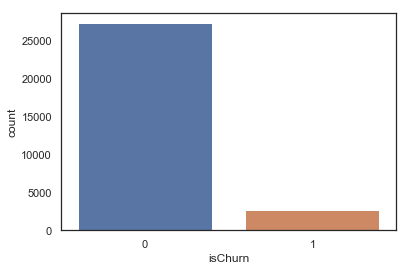

In [298]:
sns.countplot(x='isChurn',data=data_hv)

In [183]:
churn = (data_hv[data_hv.isChurn == 1].isChurn.count()/data_hv.isChurn.count())*100
no_churn = (data_hv[data_hv.isChurn == 0].isChurn.count()/data_hv.isChurn.count())*100

print('Churn % = {}'.format(churn))
print('No Churn % = {}'.format(no_churn))

Churn % = 8.789303457703976
No Churn % = 91.21069654229602


It is clear from above that we have a very imbalanced data, and will have to adopt strategies to deal with it.

In [347]:
#drop columns for month 9
s = pd.Series(data_hv.columns)
cols_to_remove = s[s.str.endswith('_9')]
data_hv = data_hv.drop(columns=cols_to_remove)

data_hv.shape

(29991, 169)

In [276]:
data_hv.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,vbc_3g_8,vbc_3g_7,vbc_3g_6,total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8,avg_rech_amt_both_1,avg_rech_amt_both_8,isChurn
7,1069.180,1349.850,3171.480,57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.0,0.0,0.00,422.16,533.91,255.79,4.30,23.29,12.01,49.89,31.76,49.14,6.66,20.08,16.68,0.0,0.0,0.0,60.86,75.14,77.84,0.0,0.18,10.01,4.50,0.00,6.50,0.00,0.0,0.0,487.53,609.24,350.16,58.14,32.26,27.31,217.56,221.49,121.19,152.16,101.46,39.53,427.88,355.23,188.04,36.89,11.83,30.39,91.44,126.99,141.33,52.19,34.24,22.21,0.0,0.0,0.0,180.54,173.08,193.94,626.46,558.04,428.74,0.21,0.0,0.0,2.06,14.53,31.59,15.74,15.19,15.14,5,5,7,1580,790,3638,1580,790,1580,6/27/2014,7/25/2014,8/26/2014,0,0,779,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.00,0.0,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,802,57.74,19.38,18.74,NaN,NaN,NaN,1185.0,3638.0,1
8,378.721,492.223,137.362,413.69,351.03,35.08,94.66,80.63,136.48,0.00,0.00,0.00,0.00,0.00,0.00,297.13,217.59,12.49,80.96,70.58,50.54,0.00,0.00,0.00,0.0,0.0,7.15,378.09,288.18,63.04,116.56,133.43,22.58,13.69,10.04,75.69,0.00,0.00,0.00,0.0,0.0,0.0,130.26,143.48,98.28,0.0,0.00,0.00,0.00,0.00,10.23,0.00,0.0,0.0,508.36,431.66,171.56,23.84,9.84,0.31,57.58,13.98,15.48,0.00,0.00,0.00,81.43,23.83,15.79,0.00,0.58,0.10,22.43,4.08,0.65,0.00,0.00,0.00,0.0,0.0,0.0,22.43,4.66,0.75,103.86,28.49,16.54,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,19,21,14,437,601,120,90,154,30,6/25/2014,7/31/2014,8/30/2014,50,0,10,NaN,

In [65]:
def create_missing_details(df,count=0):
    df_missing_values = df.isna().sum()
    df_missing_values = pd.DataFrame(df_missing_values)
    df_missing_values = df_missing_values.reset_index()
    df_missing_values.columns=['attribute','null_count']
    
    return df_missing_values[df_missing_values.null_count > count].sort_values(by='null_count',ascending=False)

In [14]:
df = create_missing_details(data_hv)
grp = df.groupby(by='null_count')
df2 = pd.DataFrame(columns=['count','features'])
for count in grp.count().reset_index().null_count:
    df = grp.get_group(count)
    values = np.sort(np.array(df.attribute))
    row = {'count':count,'features':values}
    df2=df2.append(row,ignore_index=True)
    #print('count={}, attributes={}'.format(count,values))

df2

,count,features
0,80,[date_of_last_rech_6]
1,128,[date_of_last_rech_7]
2,431,"[ic_others_6, isd_ic_mou_6, isd_og_mou_6, loc_ic_mou_6, loc_ic_t2f_mou_6, loc_ic_t2m_mou_6, loc_ic_t2t_mou_6, loc_og_mou_6, loc_og_t2c_mou_6, loc_og_t2f_mou_6, loc_og_t2m_mou_6, loc_og_t2t_mou_6, offnet_mou_6, og_others_6, onnet_mou_6, roam_ic_mou_6, roam_og_mou_6, spl_ic_mou_6, spl_og_mou_6, std_ic_mou_6, std_ic_t2f_mou_6, std_ic_t2m_mou_6, std_ic_t2o_mou_6, std_ic_t2t_mou_6, std_og_mou_6, std_og_t2c_mou_6, std_og_t2f_mou_6, std_og_t2m_mou_6, std_og_t2t_mou_6]"
3,433,"[ic_others_7, isd_ic_mou_7, isd_og_mou_7, loc_ic_mou_7, loc_ic_t2f_mou_7, loc_ic_t2m_mou_7, loc_ic_t2t_mou_7, loc_og_mou_7, loc_og_t2c_mou_7, loc_og_t2f_mou_7, loc_og_t2m_mou_7, loc_og_t2t_mou_7, offnet_mou_7, og_others_7, onnet_mou_7, roam_ic_mou_7, roam_og_mou_7, spl_ic_mou_7, spl_og_mou_7, std_ic_mou_7, std_ic_t2f_mou_7, std_ic_t2m_mou_7, std_ic_t2o_mou_7, std_ic_t2t_mou_7, std_og_mou_7, std_og_t2c_mou_7, std_og_t2f_mou_7, std_og_t2m_mou_7, std_og_t2t_mou_7]"
4,618,[date_of_last_rech_8]
5,1085,"[ic_others_8, isd_ic_mou_8, isd_og_mou_8, loc_ic_mou_8, loc_ic_t2f_mou_8, loc_ic_t2m_mou_8, loc_ic_t2t_mou_8, loc_og_mou_8, loc_og_t2c_mou_8, loc_og_t2f_mou_8, loc_og_t2m_mou_8, loc_og_t2t_mou_8, offnet_mou_8, og_others_8, onnet_mou_8, roam_ic_mou_8, roam_og_mou_8, spl_ic_mou_8, spl_og_mou_8, std_ic_mou_8, std_ic_t2f_mou_8, std_ic_t2m_mou_8, std_ic_t2o_mou_8, std_ic_t2t_mou_8, std_og_mou_8, std_og_t2c_mou_8, std_og_t2f_mou_8, std_og_t2m_mou_8, std_og_t2t_mou_8]"
6,17387,"[arpu_2g_8, arpu_3g_8, av_rech_amt_data_8, count_rech_2g_8, count_rech_3g_8, date_of_last_rech_data_8, fb_user_8, max_rech_data_8, night_pck_user_8, total_rech_amt_data_8, total_rech_data_8]"
7,17772,"[arpu_2g_7, arpu_3g_7, av_rech_amt_data_7, count_rech_2g_7, count_rech_3g_7, date_of_last_rech_data_7, fb_user_7, max_rech_data_7, night_pck_user_7, total_rech_amt_data_7, total_rech_data_7]"
8,18004,"[arpu_2g_6, arpu_3g_6, av_rech_amt_data_6, count_rech_2g_6, count_rech_3g_6, date_of_last_rech_data_6, fb_user_6, max_rech_data_6, night_pck_user_6, total_rech_amt_data_6, total_rech_data_6]"


### Analysis of Missing Values
 
1. In any month (6,7 or 8) all data related attributes are missing values at the same time indicating that in that month, user didnt use any data service.
2. Similarly all call related attributes are also null together, indicating that the user didn't use any voice service during the month.
3. date_of_last_rech_data is telling us when the last rech was done. We will use this to add a feature to record if recharge was done in the month or not. If there is a value, its 1 (recharge was done), 0(recharge was not done).
4. Given above, we will set all missing values to 0.

In [348]:
data_hv = data_hv.fillna(value=0)

In [349]:
#Add features to indicate, if the user did recharge (data or voice) in the month. 
#If date_Of_last_rech_(6/7/8)  is set, it means user did at least one voice recharge during the month
#If date_Of_last_rech_data_(6/7/8)  is set, it means user did at least one data recharge during the month

months=['6','7','8']
for month in months:
    col1='date_of_last_rech_data_'+month
    col2='date_of_last_rech_'+month
    DataRecharged = np.where((data_hv[col1] == 0),0,1)
    VoiceRecharged = np.where((data_hv[col2] == 0),0,1)
    data_hv['isDataRecharged_'+month] = DataRecharged
    data_hv['isVoiceRecharged_'+month] = VoiceRecharged
    
data_hv[['date_of_last_rech_data_6','isDataRecharged_6','date_of_last_rech_6','isVoiceRecharged_6']].head()    




,date_of_last_rech_data_6,isDataRecharged_6,date_of_last_rech_6,isVoiceRecharged_6
7,0,0,6/27/2014,1
8,0,0,6/25/2014,1
13,0,0,6/20/2014,1
16,0,0,6/30/2014,1
17,0,0,6/30/2014,1


In [350]:
#We can now drop date_of_last_rech_data_6 and date_of_last_rech_6/7/8
data_hv = data_hv.drop(columns=['date_of_last_rech_data_6','date_of_last_rech_6',
                                  'date_of_last_rech_data_8','date_of_last_rech_8',
                                 'date_of_last_rech_data_7','date_of_last_rech_7'])
print(data_hv.shape)

(29991, 169)


In [225]:
print(len(data_hv[~(data_hv.total_rech_data_6 == (data_hv.count_rech_2g_6 +data_hv.count_rech_3g_6))].index))

print(len(data_hv[~(data_hv.total_rech_data_7 == (data_hv.count_rech_2g_7 +data_hv.count_rech_3g_7))].index))

print(len(data_hv[~(data_hv.total_rech_data_8 == (data_hv.count_rech_2g_8 +data_hv.count_rech_3g_8))].index))


0
0
0


###### From above response, it is clear that total_rech_data=count_rech_2g + count_rech_3g

Since we have large number of columns and actually we have same attributes for different months, we will distribute the data in 3 different dataframe one for each month 6, 7 and 8. We will do EDA and further cleaning on each data set, and will then merge them.

In [143]:
#Function to extract month specific attributes.
def extract_month_data(month):
    s = pd.Series(data_hv.columns)
    mon_str = '_'+month
    mon_cols = s[(s.str.endswith(mon_str))]
    
    return data_hv[mon_cols]

In [303]:
data_hv_6 = extract_month_data('6')
data_hv_7 = extract_month_data('7')
data_hv_8 = extract_month_data('8')

print('Month 6 shape: {}'.format(data_hv_6.shape))
print('Month 7 shape: {}'.format(data_hv_7.shape))
print('Month 8 shape: {}'.format(data_hv_8.shape))

Month 6 shape: (29991, 55)
Month 7 shape: (29991, 55)
Month 8 shape: (29991, 56)


###### Note:
Tha additional columne for month 8 is avg_rech_amt_both_8.
For month 6 and 7 we have added the average of both month in column avg_rech_amt_both_1

In [145]:
print('Month 6-{}'.format(data_hv_6.shape))
print('Month 7-{}'.format(data_hv_7.shape))
print('Month 8-{}'.format(data_hv_8.shape))
print('Over All-{}'.format(data_hv.shape))

Month 6-(29991, 55)
Month 7-(29991, 55)
Month 8-(29991, 56)
Over All-(29991, 169)


### Merge data from month 6 and 7 as 1 by taking a average of values. We will use suffix _1 to indicate merge field from month 6 and 7

In [304]:
#Function to extract month specific attributes.
def add_avg_month_6_7(df):
    df_copy = df.copy(deep=True)
    mon_6_cols = extract_month_data('6').columns.sort_values()
    
    mon_7_cols = extract_month_data('7').columns.sort_values()

    
    for indx in range(0,len(mon_6_cols)):
        col6 = mon_6_cols[indx]
        col7 = mon_7_cols[indx]
        new_col = col6.replace('_6','_1')
        if ~(col6 == 'isVoiceRecharged_6') & ~(col6 == 'isVoiceRecharged'):
            df_copy[new_col]=np.mean(df_copy[[col6,col7]],axis=1)
     
    df_copy['isVoiceRecharged_1'] = np.where((df['isVoiceRecharged_6']== False) & (df['isVoiceRecharged_7']==False),0,1)
    df_copy['isDataRecharged_1'] = np.where((df['isDataRecharged_6']== False) & (df['isDataRecharged_7']==False),0,1)
    df_copy['night_pck_user_1'] = np.where((df['night_pck_user_6']== False) & (df['night_pck_user_7']==False),0,1)
    df_copy['fb_user_1'] = np.where((df['fb_user_6']== False) & (df['fb_user_7']==False),0,1)
    
    
    return df_copy
        
        

In [351]:
data_hv = add_avg_month_6_7(data_hv)
print(data_hv.shape)
################
#Remove columns of month 6 and 7
cols_to_remove = extract_month_data('6').columns
data_hv = data_hv.drop(columns=cols_to_remove)

cols_to_remove = extract_month_data('7').columns
data_hv = data_hv.drop(columns=cols_to_remove)

data_hv.shape

(29991, 224)


(29991, 114)

In [101]:
#drop std_og_t2c_mou_1/8	 and std_ic_t2o_mou_1/8 since they have only 0 in all rows. 
print(data_hv.std_og_t2c_mou_1.unique())
print(data_hv.std_og_t2c_mou_8.unique())

print(data_hv.std_ic_t2o_mou_1.unique())
print(data_hv.std_ic_t2o_mou_8.unique())

[0.]
[0.]
[0.]
[0.]


In [352]:
data_hv = data_hv.drop(columns=['std_og_t2c_mou_1','std_ic_t2o_mou_1','std_og_t2c_mou_8','std_ic_t2o_mou_8'])
data_hv.shape

(29991, 110)

In [75]:
df1 = extract_month_data('1')
df_describe_1 = df1.describe()
df_describe_1 = df_describe_1.reset_index()
#temp.drop(columns=['mobile_number','isChurn','isDataRecharged_6','isRecharged_6'],inplace=True)
df_describe_1.head(20)

,index,avg_rech_amt_both_1,arpu_2g_1,arpu_3g_1,arpu_1,av_rech_amt_data_1,count_rech_2g_1,count_rech_3g_1,fb_user_1,ic_others_1,isDataRecharged_1,isVoiceRecharged_1,isd_ic_mou_1,isd_og_mou_1,last_day_rch_amt_1,loc_ic_mou_1,loc_ic_t2f_mou_1,loc_ic_t2m_mou_1,loc_ic_t2t_mou_1,loc_og_mou_1,loc_og_t2c_mou_1,loc_og_t2f_mou_1,loc_og_t2m_mou_1,loc_og_t2t_mou_1,max_rech_amt_1,max_rech_data_1,monthly_2g_1,monthly_3g_1,night_pck_user_1,offnet_mou_1,og_others_1,onnet_mou_1,roam_ic_mou_1,roam_og_mou_1,sachet_2g_1,sachet_3g_1,spl_ic_mou_1,spl_og_mou_1,std_ic_mou_1,std_ic_t2f_mou_1,std_ic_t2m_mou_1,std_ic_t2t_mou_1,std_og_mou_1,std_og_t2f_mou_1,std_og_t2m_mou_1,std_og_t2t_mou_1,total_ic_mou_1,total_og_mou_1,total_rech_amt_1,total_rech_amt_data_1,total_rech_data_1,total_rech_num_1,vbc_3g_1,vol_2g_mb_1,vol_3g_mb_1
0,count,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.00000,29991.000000,29991.000000,29991.000000,29991.000000,29991.0,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000
1,mean,762.256571,54.849437,58.885206,568.889773,109.882084,1.09006,0.382982,0.437131,1.281591,0.472675,1.0,10.928200,2.191255,101.167350,232.103931,15.029982,152.225133,64.839161,263.693047,1.696177,6.607717,170.292176,86.784718,167.072055,58.460138,0.117052,0.187406,0.015638,399.181667,0.369972,283.428743,14.746128,24.601668,0.973009,0.195575,0.041459,6.476875,49.420716,2.723910,30.887184,15.805849,387.664355,1.924409,198.827586,186.908311,293.783945,660.404387,673.291437,449.669633,1.473042,12.094295,140.589129,93.568475,299.818841
2,std,733.313034,145.650877,161.360213,422.455128,186.246764,2.40036,1.106576,0.496040,13.099277,0.499261,0.0,63.318112,44.785814,115.718027,292.238383,42.654674,204.799065,144.875691,356.660858,6.649115,21.295396,232.614274,219.818412,155.445276,100.038337,0.329238,0.555218,0.124073,450.250381,2.537718,437.245784,66.680557,94.269412,2.389557,0.934360,0.151785,18.046395,133.325671,18.013977,93.929001,75.584954,579.100383,11.788151,395.299730,388.771419,340.482455,631.011221,505.490386,1249.365550,2.752382,8.681478,379.145065,272.685561,829.119453
3,min,374.250000,-7.740000,-8.585000,-749.783000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000
4,25%,455.500000,0.000000,0.000000,361.217250,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,32.000000,58.017500,0.140000,35.347500,9.250000,44.627500,0.000000,0.000000,27.370000,7.820000,98.000000,0.000000,0.000000,0.000000,0.000000,115.767500,0.000000,32.735000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.430000,0.000000,1.080000,0.000000,4.640000,0.000000,1.695000,0.000000,89.125000,241.715000,428.000000,0.000000,0.000000,6.500000,0.000000,0.000000,0.000000
5,50%,578.000000,0.000000,0.000000,480.466500,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,77.000000,141.370000,2.460000,89.170000,28.190000,145.605000,0.000000,0.630000,89.720000,29.465000,120.000000,0.000000,0.000000,0.000000,0.000000,276.185000,0.000000,117.100000,0.000000,0.000000,0.000000,0.000000,0.000000,1.650000,16.135000,0.000000,8.010000,1.820000,117.2700

In [76]:
df8 = extract_month_data('8')
df_describe_8 = df8.describe()
df_describe_8 = df_describe_8.reset_index()
#temp.drop(columns=['mobile_number','isChurn','isDataRecharged_6','isRecharged_6'],inplace=True)
df_describe_8

,index,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,std_og_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,total_og_mou_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,loc_ic_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,std_ic_mou_8,total_ic_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,total_rech_data_8,max_rech_data_8,count_rech_2g_8,count_rech_3g_8,av_rech_amt_data_8,vol_2g_mb_8,vol_3g_mb_8,arpu_3g_8,arpu_2g_8,night_pck_user_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,fb_user_8,vbc_3g_8,total_rech_amt_data_8,avg_rech_amt_both_8,isDataRecharged_8,isVoiceRecharged_8
0,count,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000,29991.000000
1,mean,515.599854,251.858760,355.357505,12.705209,20.600759,79.603055,157.342410,6.066840,1.696596,243.020260,164.342787,171.427254,1.670426,337.444110,1.975568,6.630528,0.053456,589.131841,61.488379,146.263657,13.527515,221.288873,14.387955,28.673707,2.510342,45.575528,279.089545,0.028391,10.999306,1.189969,10.274416,591.413958,156.792304,91.942283,1.383748,56.213497,1.024641,0.359108,99.710398,82.205970,293.808860,54.240188,50.188732,0.010003,0.103064,0.921576,0.176520,0.182588,0.365343,138.889896,411.438456,657.833796,0.420259,0.979394
2,std,498.844711,461.923802,480.716732,73.873083,105.265854,225.488380,234.173422,19.903724,7.329128,362.419345,405.818444,414.337195,11.388319,613.693485,44.700783,22.170062,3.226854,692.951252,146.198644,212.724728,40.109738,298.601842,71.689239,103.886122,19.607052,138.908977,353.248950,0.116090,73.046184,12.090293,9.470009,608.076000,173.626783,144.854913,2.952737,105.794166,2.462610,1.252412,192.604100,289.211851,897.432541,166.025201,148.727369,0.099515,0.343201,2.449459,0.588755,1.080861,0.481534,400.507128,1611.853803,964.380611,0.493609,0.142064
3,min,-945.808000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-24.490000,-10.370000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,25%,253.605500,16.370000,64.890000,0.000000,0.000000,3.410000,15.400000,0.000000,0.000000,26.190000,0.000000,0.000000,0.000000,0.210000,0.000000,0.000000,0.000000,119.605000,5.290000,24.970000,0.000000,42.110000,0.000000,0.000000,0.000000,0.760000,65.475000,0.000000,0.000000,0.000000,4.000000,260.000000,50.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,279.000000,0.000000,1.000000
5,50%,432.608000,82.960000,216.360000,0.000000,0.000000,23.160000,74.430000,0.000000,0.000000,120.880000,2.940000,16.680000,0.000000,48.990000,0.000000,0.430000,0.000000,399.360000,23.610000,81.190000,1.530000,129.390000,0.310000,4.540000,0.000000,10.640000,175.460000,0.000000,0.000000,0.000000,8.000000,499.000000,130.000000,50.000000,0.000000,0.000000,0.000000,0.000

From above we see that we may have outlier issue

In [307]:
## Create a dataframe where we store corresponding label for each month.
df1 = extract_month_data('1')
df8=extract_month_data('8')
rows = {'mon_1':df1.columns.sort_values(),'mon_8':df8.columns.sort_values()}
attr_df = pd.DataFrame(data = rows)
attr_df.iloc[[0], [1]] = 'arpu_8'
attr_df.iloc[[1], [1]] = 'arpu_2g_8'
attr_df.iloc[[2], [1]] = 'arpu_3g_8'
attr_df

,mon_1,mon_8
0,arpu_1,arpu_8
1,arpu_2g_1,arpu_2g_8
2,arpu_3g_1,arpu_3g_8
3,av_rech_amt_data_1,av_rech_amt_data_8
4,avg_rech_amt_both_1,avg_rech_amt_both_8
5,count_rech_2g_1,count_rech_2g_8
6,count_rech_3g_1,count_rech_3g_8
7,fb_user_1,fb_user_8
8,ic_others_1,ic_others_8
9,isDataRecharged_1,isDataRecharged_8


In [353]:
print(df1.shape)
print(df8.shape)
print(data_hv.shape)

(29991, 54)
(29991, 54)
(29991, 110)


In [202]:
attr_df.head()

,mon_1,mon_8
0,arpu_1,arpu_8
1,arpu_2g_1,arpu_2g_8
2,arpu_3g_1,arpu_3g_8
3,av_rech_amt_data_1,av_rech_amt_data_8
4,avg_rech_amt_both_1,avg_rech_amt_both_8


In [125]:
import matplotlib.pyplot as plt

## Function to draw scatter plt for corresponding feature of each month
def plot_scatter(df,start,end,df_cols):
    fig, axes = plt.subplots(nrows=(end-start), ncols=2)
    fig.set_figwidth(20)
    fig.set_figheight(15)
    fig.subplots_adjust(hspace=2.5)
    fig.suptitle('Scatter plot of features')
    y_col='isChurn'

    attributes = []
    for indx in range(start,end):
        #print(indx)
        attributes.append(df_cols.iloc[[indx],[0]].mon_1.str.split(" ").get(indx)[0])
        attributes.append(df_cols.iloc[[indx],[1]].mon_8.str.split(" ").get(indx)[0])
    
    #print(attributes)
    for ax, feature in zip(axes.flatten(),attributes):
        sns.scatterplot(df[feature],df[y_col],ax=ax)
        ax.set(xlabel=feature)
     
    #plt.show()  


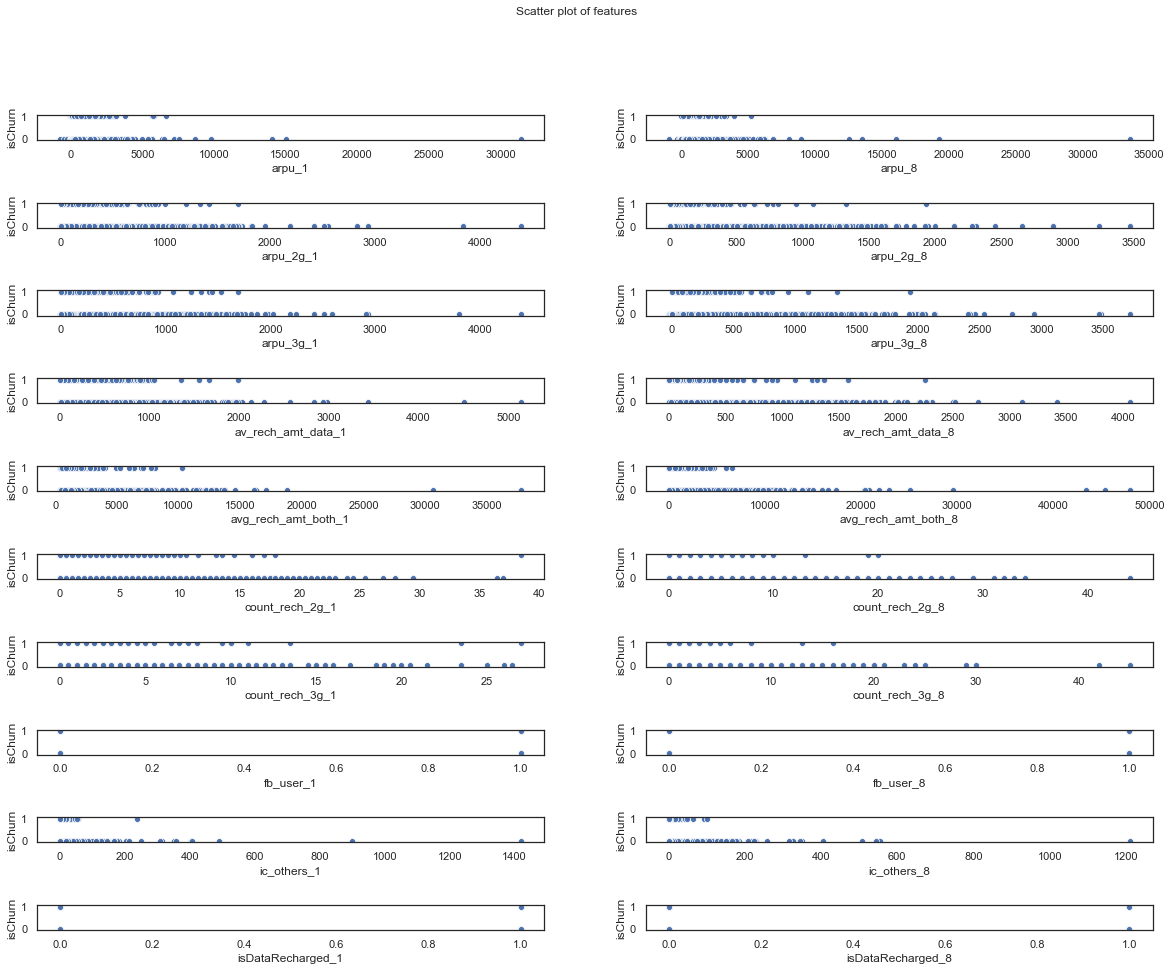

In [329]:
plot_scatter(data_hv,0,10,attr_df)

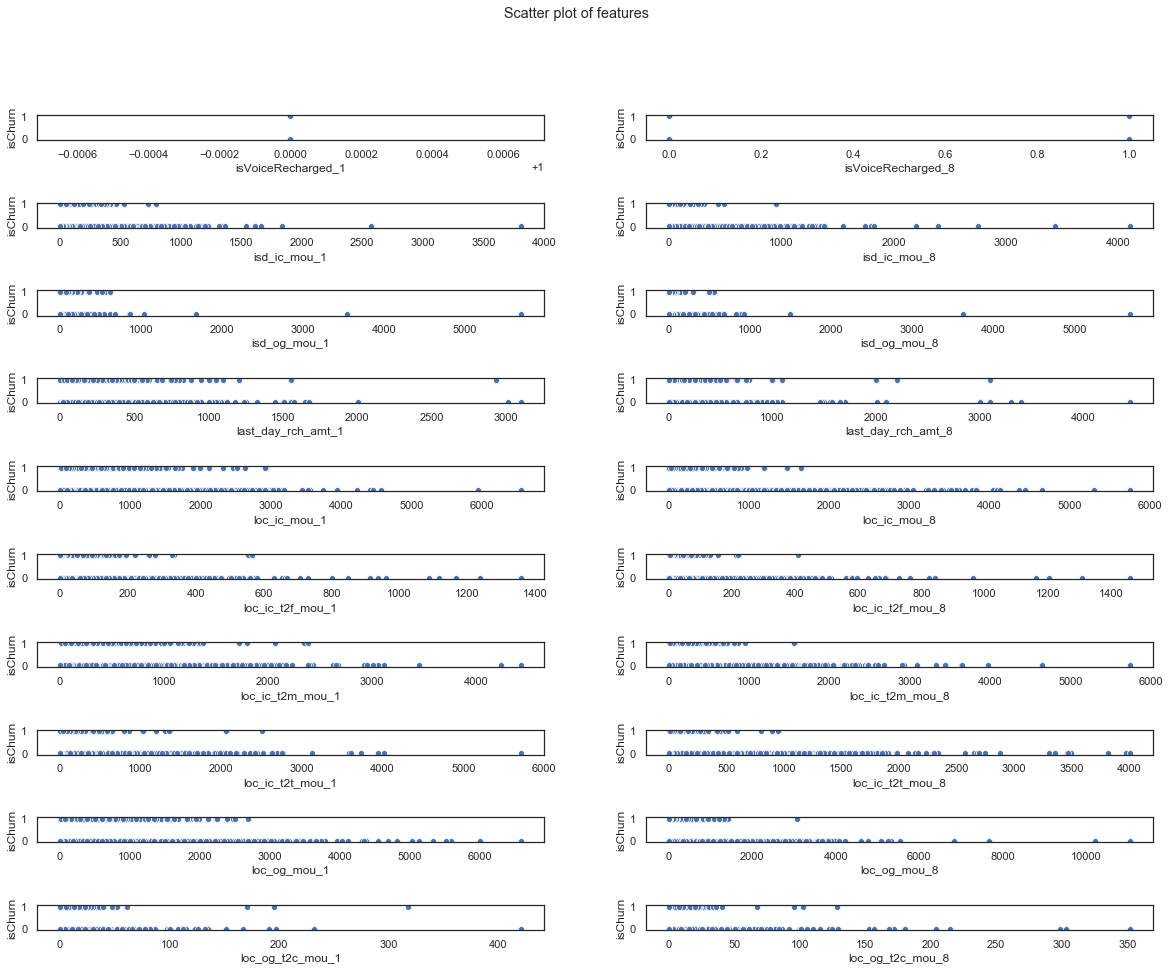

In [126]:
plot_scatter(data_hv,10,20,attr_df)

In [266]:
data_hv[['isVoiceRecharged_1','isChurn']].head()

,isVoiceRecharged_1,isChurn
7,1,1
8,1,0
13,1,0
16,1,0
17,1,0


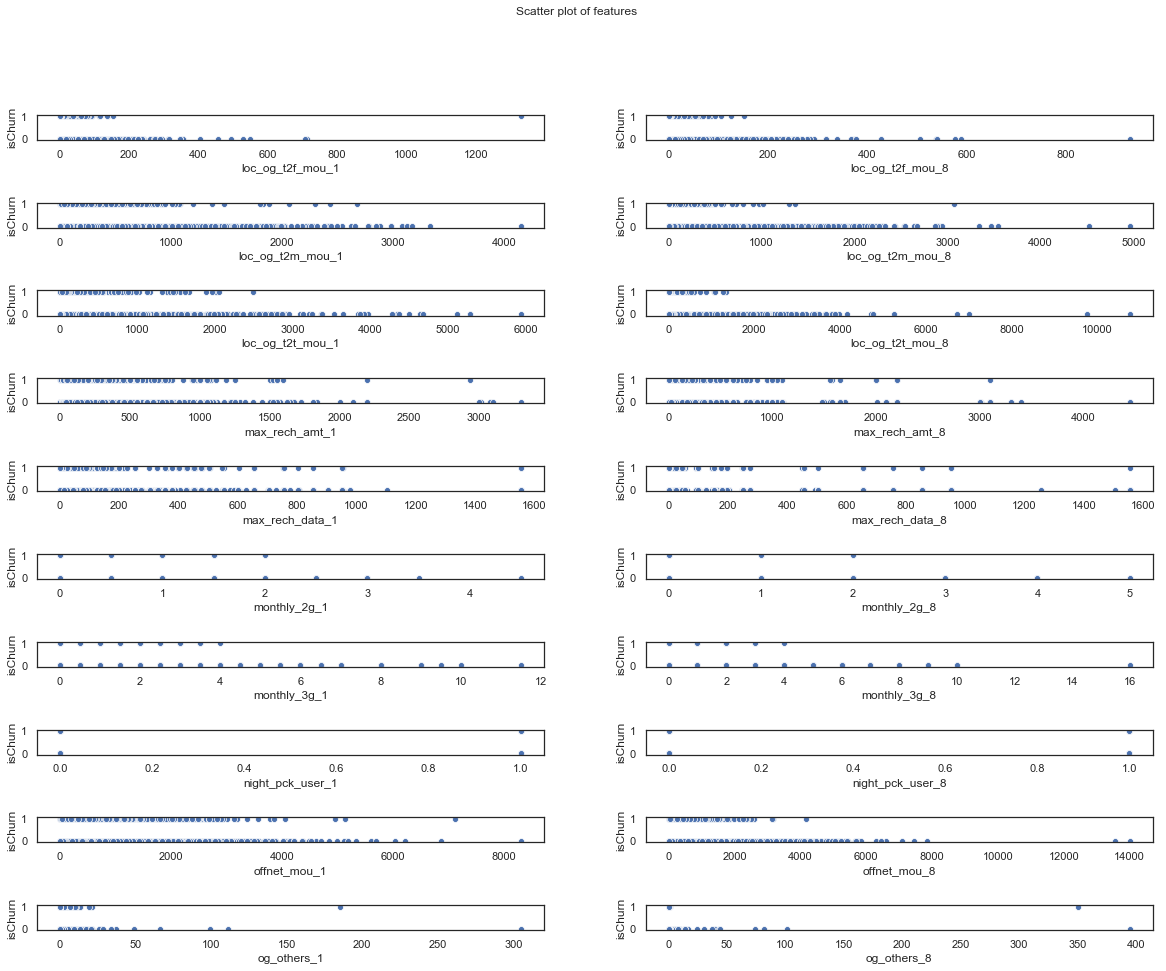

In [330]:
plot_scatter(data_hv,20,30,attr_df)

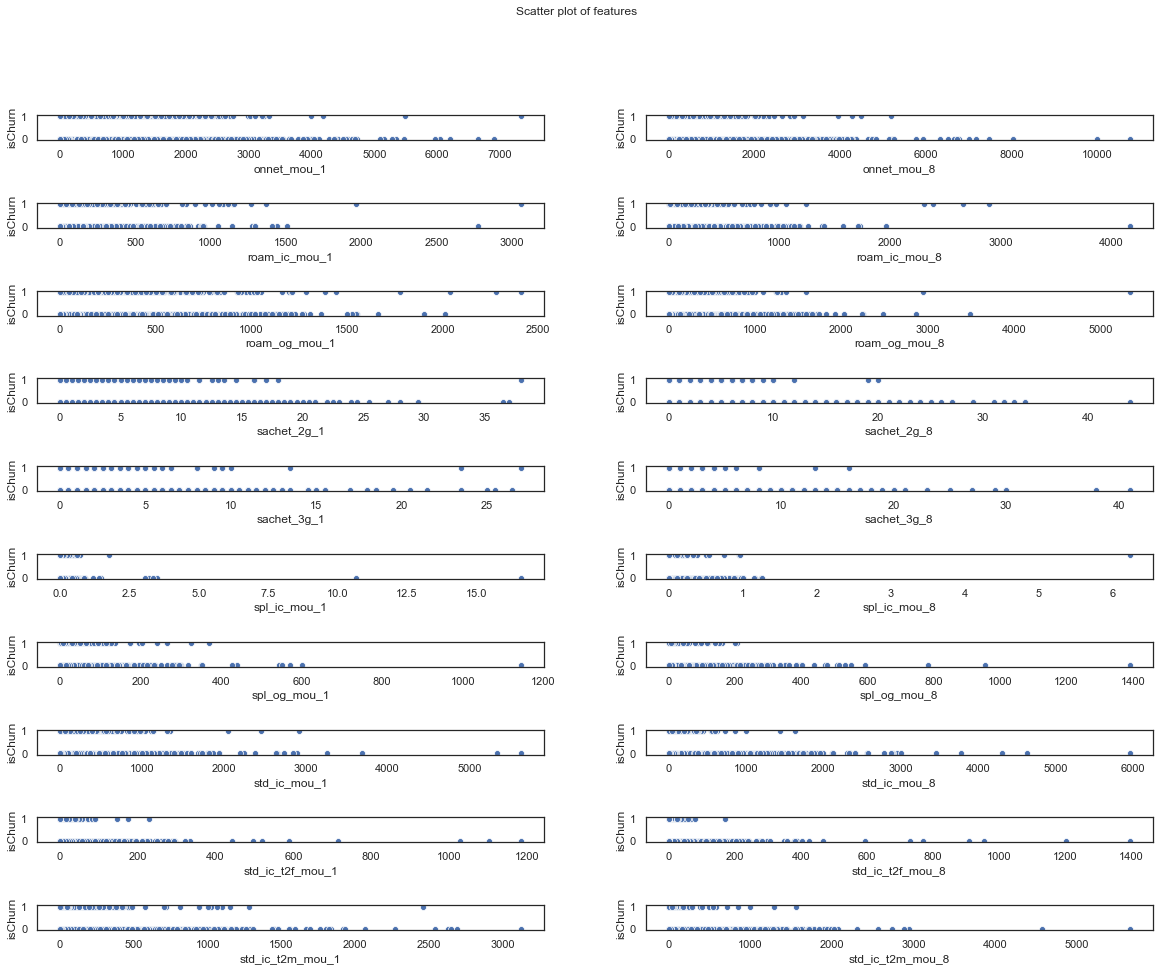

In [257]:
plot_scatter(data_hv,30,40,attr_df)

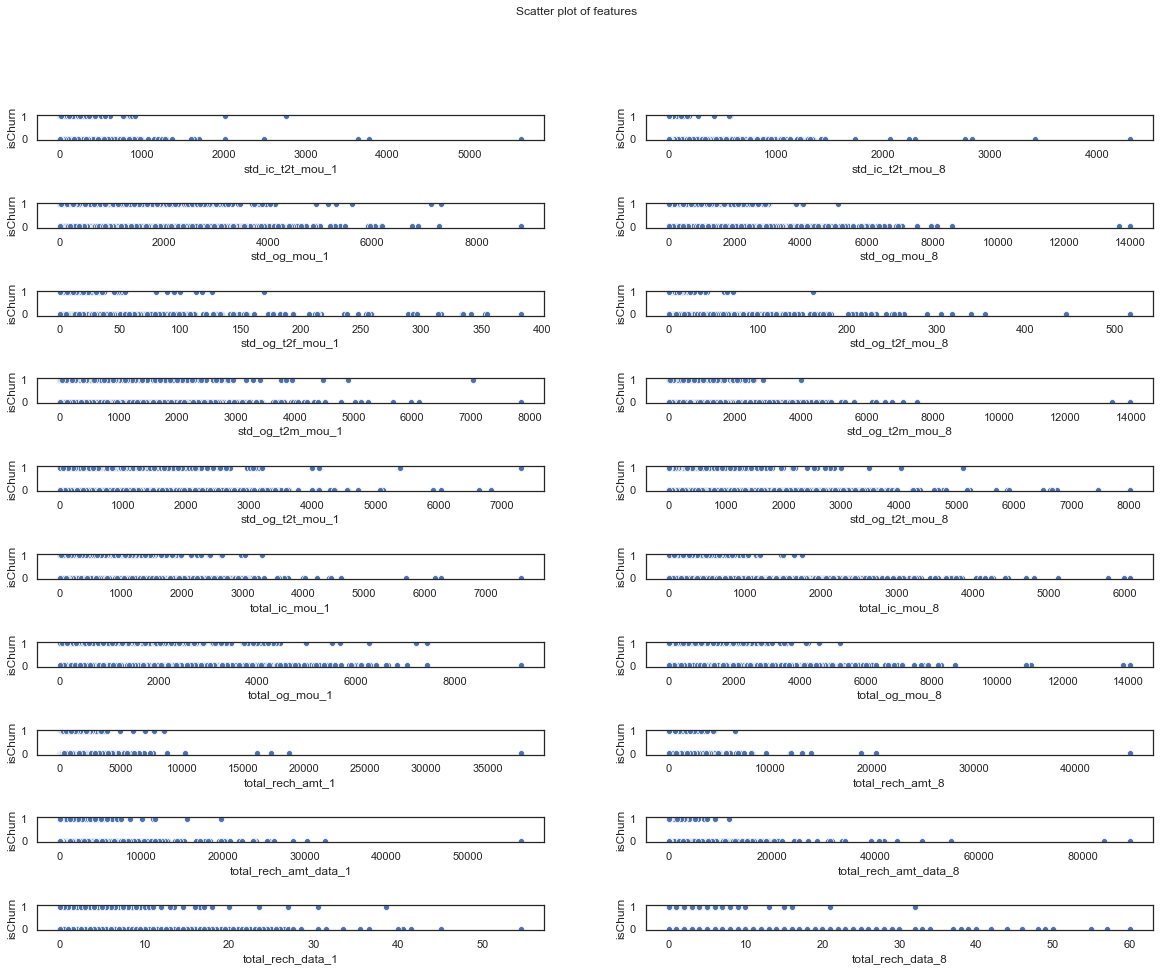

In [259]:
plot_scatter(data_hv,40,50,attr_df)

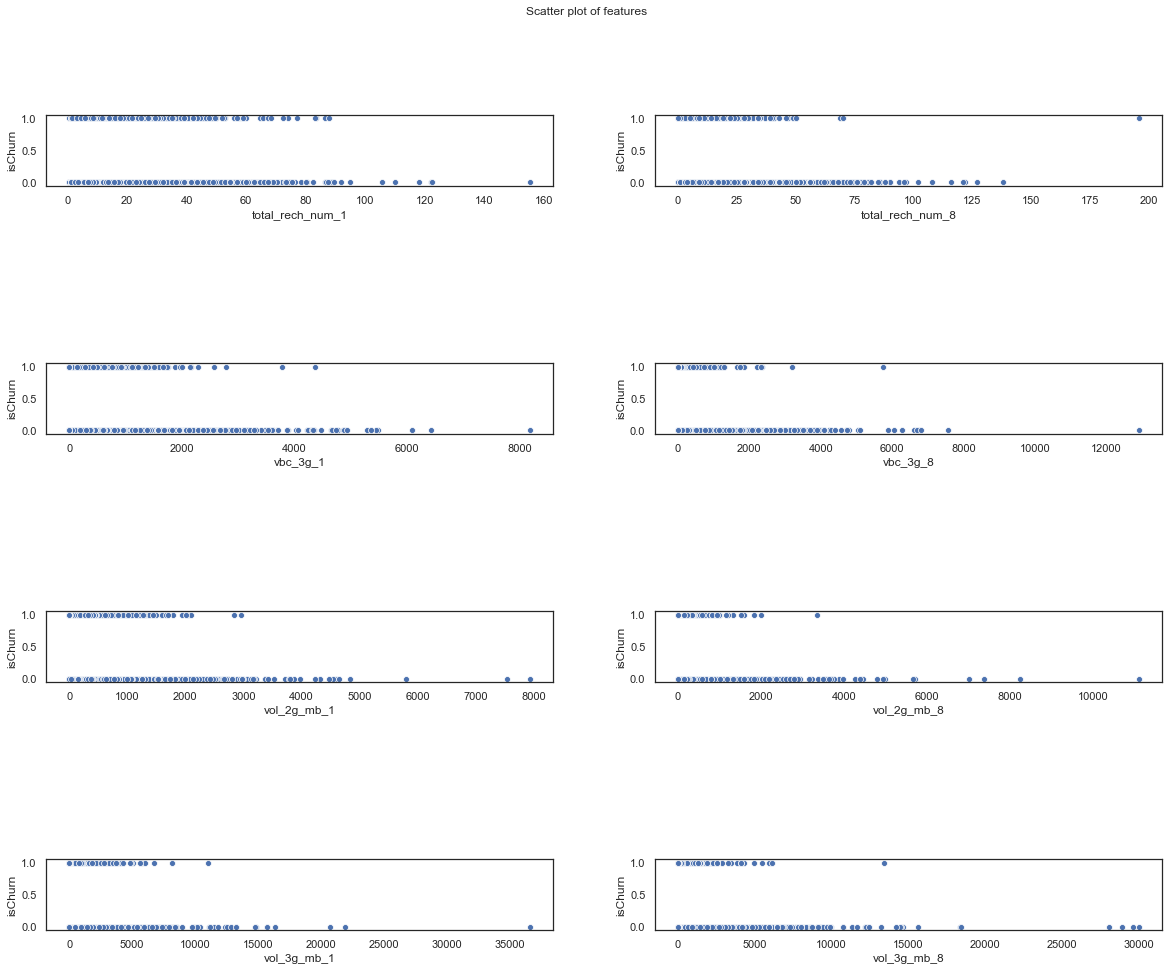

In [261]:
plot_scatter(data_hv,50,54,attr_df)

### From above scatter graphs, we seems to have outliers. We will use DBScan to find outliers and remove them

In [287]:
data_hv.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27140 entries, 8 to 99997
Data columns (total 110 columns):
arpu_8                   float64
onnet_mou_8              float64
offnet_mou_8             float64
roam_ic_mou_8            float64
roam_og_mou_8            float64
loc_og_t2t_mou_8         float64
loc_og_t2m_mou_8         float64
loc_og_t2f_mou_8         float64
loc_og_t2c_mou_8         float64
loc_og_mou_8             float64
std_og_t2t_mou_8         float64
std_og_t2m_mou_8         float64
std_og_t2f_mou_8         float64
std_og_mou_8             float64
isd_og_mou_8             float64
spl_og_mou_8             float64
og_others_8              float64
total_og_mou_8           float64
loc_ic_t2t_mou_8         float64
loc_ic_t2m_mou_8         float64
loc_ic_t2f_mou_8         float64
loc_ic_mou_8             float64
std_ic_t2t_mou_8         float64
std_ic_t2m_mou_8         float64
std_ic_t2f_mou_8         float64
std_ic_mou_8             float64
total_ic_mou_8           float64

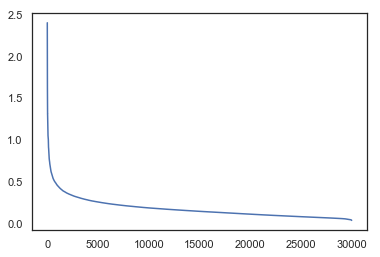

In [354]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer


#Remove target attributes
cols_to_remove = ['isChurn']
    

df = data_hv.copy(deep=True)
df = df.drop(columns=cols_to_remove)
scaler = MinMaxScaler()
#scaler = StandardScaler()
df = scaler.fit_transform(df)
#df = pd.DataFrame(df, columns = data_hv.columns)

ns = 5
nbrs = NearestNeighbors(n_neighbors=ns).fit(df)
distances, indices = nbrs.kneighbors(df)
distanceDec = sorted(distances[:,ns-1], reverse=True)
plt.plot(indices[:,0], distanceDec)

In [355]:
#From above we see elbow at 0.6, so lets use it as eps to find outliers using DBScan

outlier_detection = DBSCAN(
  eps = .6,
  metric="euclidean",
  min_samples = 120,
  n_jobs = -1)
clusters = outlier_detection.fit_predict(df)
clusters

array([0, 1, 2, ..., 0, 1, 1])

In [356]:
#outlier_detection.labels_
np.unique(outlier_detection.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [357]:
outliers = data_hv[outlier_detection.labels_==-1]
print(outliers.shape)
print(outliers[outliers.isChurn==1].shape)
print(outliers[outliers.isChurn==0].shape)

(813, 110)
(65, 110)
(748, 110)


### Based on above, we will remove the outliers

In [358]:
data_hv_new = data_hv.copy(deep=True)
data_hv_new['label'] = outlier_detection.labels_
data_hv_new = data_hv_new[data_hv_new.label != -1]
data_hv_new=data_hv_new.drop(columns='label')
data_hv_new.shape

(29178, 110)

In [86]:
def extract_similar_cols_data(df,col_pattern):
    s = pd.Series(df.columns)
    cols = s[s.str.contains(col_pattern)]
    
    return df[cols]

In [87]:
#Month 6&7
df = extract_similar_cols_data(data_hv,'std_og')
df = df.assign(std_diff = round(df.std_og_t2t_mou_1+df.std_og_t2m_mou_1+df.std_og_t2f_mou_1 - df.std_og_mou_1,2))
len(df[abs(df.std_diff)>0.02].sort_values(by='std_diff', ascending=True).index)


0

In [88]:
#Month 8
df = extract_similar_cols_data(data_hv,'std_og')
df = df.assign(std_diff = round(df.std_og_t2t_mou_8+df.std_og_t2m_mou_8+df.std_og_t2f_mou_8 - df.std_og_mou_8,2))
len(df[abs(df.std_diff)>.02].sort_values(by='std_diff', ascending=True).index)

0

From above we can see that <b>sum(std_og_t2t_mou, std_og_t2m_mou, std_og_t2f_mou) =(up to .02) of std_og_mou</b>

In [361]:
#Month 6&7
df = extract_similar_cols_data(data_hv,'std_ic')
df = df.assign(std_diff = round(df.std_ic_t2t_mou_1+df.std_ic_t2m_mou_1+df.std_ic_t2f_mou_1 - df.std_ic_mou_1,2))
len(df[abs(df.std_diff)>.02].sort_values(by='std_diff', ascending=True).index)



0

In [362]:
#Month 8
df = extract_similar_cols_data(data_hv,'std_ic')
df = df.assign(std_diff = round(df.std_ic_t2t_mou_8+df.std_ic_t2m_mou_8+df.std_ic_t2f_mou_8 - df.std_ic_mou_8,2))
len(df[abs(df.std_diff)>.02].sort_values(by='std_diff', ascending=True).index)

0

From above we can see that <b>sum(std_ic_t2t_mou, std_ic_t2m_mou, std_ic_t2f_mou) =(up to .02) of std_ic_mou</b>

For local Outgoing, we don't have similar co-relation as in std_og

In [89]:
#Function to create correlation graph for particular month
def corr_graph(df,month):
    data = extract_similar_cols_data(df,month)
    corr = data.corr()
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
    fig.colorbar(cax)
    ticks = np.arange(0,len(data.columns),1)
    ax.set_xticks(ticks)
    plt.xticks(rotation=90)
    ax.set_yticks(ticks)
    ax.set_xticklabels(data.columns)
    ax.set_yticklabels(data.columns)
    plt.show()

In [152]:
            
        # function to List hig correlated feature for month
def list_corr_attributes(df,month,min_corr=.9):
    #df = extract_similar_cols_data(df,month)
    df = pd.DataFrame(df.corr().abs().unstack().sort_values(ascending=False))
    df = df.reset_index()
    df.columns=['attribute1','attribute2','corr_val']
    
    return df[(df.attribute1 != df.attribute2) & (df.corr_val > min_corr)]    

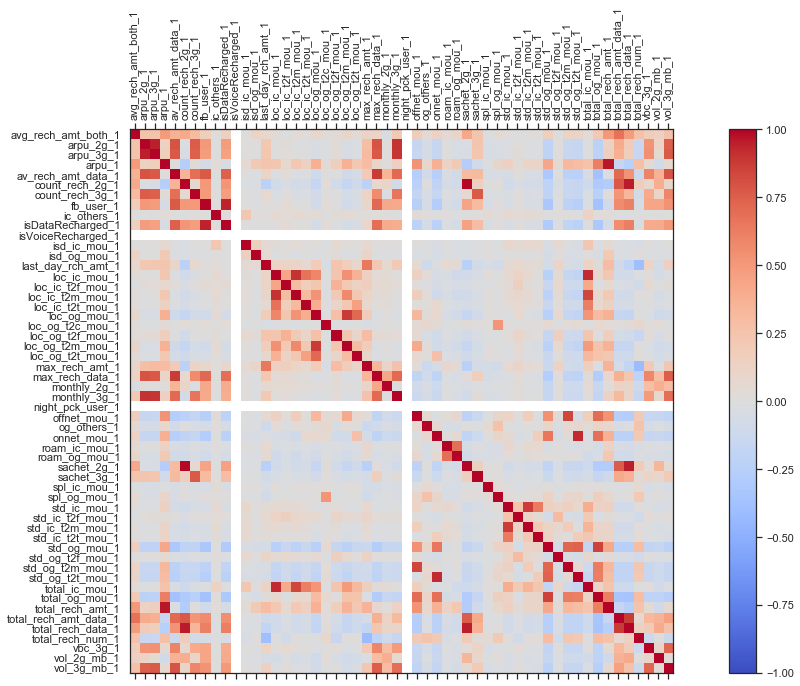

In [384]:
#Check correlation between attributes(average of month6/7)
corr_graph(data_hv,'_1')

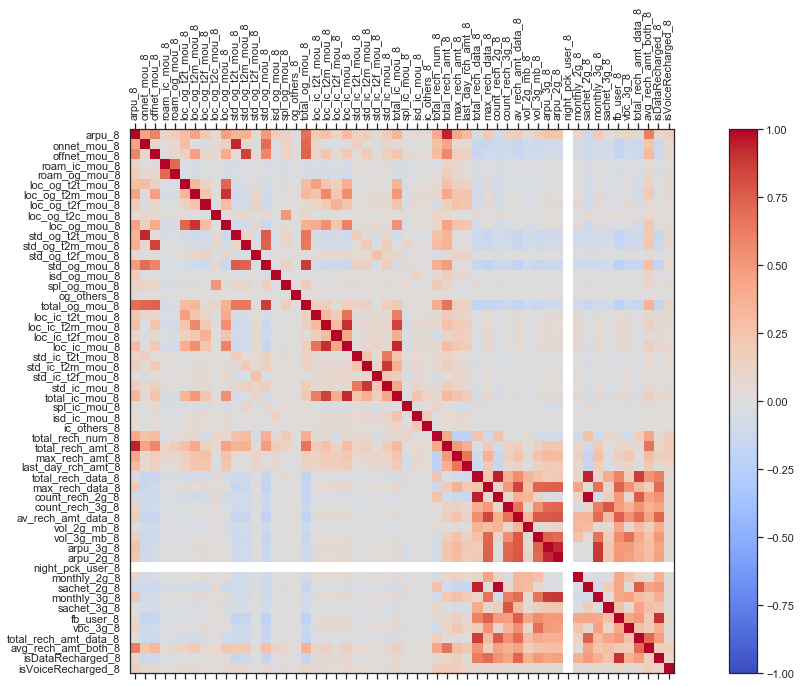

In [400]:
#Check correlation between attributes of month 8

corr_graph(data_hv,'_8')


In [359]:
df= list_corr_attributes(data_hv_new,'_8',.9)
print(len(df.index))
df

26


,attribute1,attribute2,corr_val
108,sachet_2g_1,count_rech_2g_1,0.989820
109,count_rech_2g_1,sachet_2g_1,0.989820
110,count_rech_2g_8,sachet_2g_8,0.989236
111,sachet_2g_8,count_rech_2g_8,0.989236
112,total_rech_amt_1,arpu_1,0.972609
113,arpu_1,total_rech_amt_1,0.972609
114,arpu_2g_1,arpu_3g_1,0.949215
115,arpu_3g_1,arpu_2g_1,0.949215
116,arpu_8,total_rech_amt_8,0.947244
117,total_rech_amt_8,arpu_8,0.947244


In [360]:
#Remove attributes that are showing high collinearity.

cols_to_remove=df.attribute1
data_hv_reduced = data_hv_new.drop(columns=cols_to_remove)
data_hv_reduced.shape

(29178, 90)

## Start Model

Since we have a imbalance data set, we will not rely on accruacy as evaluation metrics. Instead we will rely on f1-score that provides a balance between precision and recall (how accuratey model identifies the churn). 

We will assume that while it is important for business to identify the churn cases so that they can come up with some plans or incentives so that they dont leave, it is also important that the model is not classifying non-churn cases as churn to save cost.

In [201]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [157]:
from sklearn import metrics

def check_score(model,X_test_train,y_test_train,test_or_train='Train'):
    y_pred = model.predict(X_test_train)
    
    print('precision_score({})={}'.format(test_or_train,metrics.precision_score(y_test_train,y_pred)))
    print('roc_auc_score({})={}'.format(test_or_train,metrics.roc_auc_score(y_test_train,y_pred)))
    print('recall_score({})={}'.format(test_or_train,metrics.recall_score(y_test_train,y_pred)))
    print('f1_score({})={}'.format(test_or_train,metrics.f1_score(y_test_train,y_pred)))
    

#### Handle Imbalanced data using SMOTE


In [361]:
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X = data_hv_reduced.drop(columns='isChurn')
y = data_hv_reduced['isChurn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=872)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)


X_train:  (20424, 89)
X_test:  (8754, 89)


In [326]:
def apply_smote(X_train,y_train):
    print("Before SMOTE, Churn Count: {}".format(sum(y_train==1)))
    print("Before SMOTE, No-Churn Count: {} \n".format(sum(y_train==0)))

    sm = SMOTE(random_state=267)
    X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())
    #X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

    print("After SMOTE, Churn Count: {}".format(sum(y_train_res==1)))
    print("After SMOTE No-Churn Count: {}".format(sum(y_train_res==0)))
    
    return X_train_res,y_train_res

In [362]:
X_train_res,y_train_res = apply_smote(X_train,y_train)

Before SMOTE, Churn Count: 1799
Before SMOTE, No-Churn Count: 18625 

After SMOTE, Churn Count: 18625
After SMOTE No-Churn Count: 18625


In [363]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import  auc, roc_auc_score, roc_curve, recall_score, classification_report,f1_score

parameters = {
    'C': np.linspace(1, 10, 10)
             }
lr = LogisticRegression()
clf = GridSearchCV(lr, parameters, cv=5, verbose=0, n_jobs=3,scoring='f1')
clf.fit(X_train_res, y_train_res.ravel())

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=3,
       param_grid={'C': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [364]:
#Lets check the selected parameter.
clf.best_params_


{'C': 5.0}

In [365]:
lr1 = LogisticRegression(C=5,penalty='l1', verbose=0)
lr1.fit(X_train_res, y_train_res.ravel())

LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

precision_score(Train)=0.3214133673903789
roc_auc_score(Train)=0.8340937060484759
recall_score(Train)=0.839355197331851
f1_score(Train)=0.46482992150223185


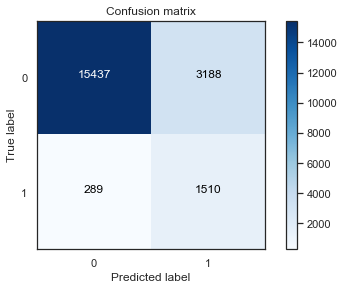

In [366]:
y_train_pre = lr1.predict(X_train)

cnf_matrix_tra = confusion_matrix(y_train, y_train_pre)

check_score(lr1,X_train,y_train,'Train')

class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix')
plt.show()

precision_score(Test)=0.3324579831932773
roc_auc_score(Test)=0.830576785832079
recall_score(Test)=0.823146944083225
f1_score(Test)=0.4736251402918069


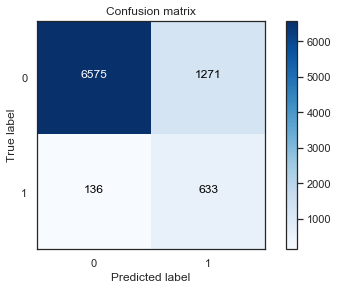

In [332]:
y_pre = lr1.predict(X_test)

cnf_matrix = confusion_matrix(y_test, y_pre)

check_score(lr1,X_test,y_test,'Test')

class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix , classes=class_names, title='Confusion matrix')
plt.show()


From above we observe that Logistic Regerssion model is not able to provide a good f1-score. We will try other models.

### Dimensionality reduction using PCA

In [333]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing


X = data_hv_reduced.drop(columns=['isChurn'])
y = data_hv_reduced.isChurn

scaler = preprocessing.StandardScaler()
X=scaler.fit_transform(X)



# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=100)
print(X_train.shape)
print(X_test.shape)


(20101, 87)
(8615, 87)


In [334]:
from sklearn.decomposition import PCA

pca = PCA(0.95)

In [404]:
X_train_pca = pca.fit_transform(X_train)
print(X_train_pca.shape)
X_test_pca = pca.transform(X_test)
print(X_test_pca.shape)


(20424, 50)
(8754, 50)


So we see that with just 50 principal components, we are able to retain 95% of the variance. Let's use it to try other models

# Apply RandomClassifier With SMOTE

In [405]:
from sklearn.ensemble import RandomForestClassifier
rfc_model = RandomForestClassifier()

#Apply SMOTE to balance data
X_train_res,y_train_res = apply_smote(X_train_pca,y_train)



Before SMOTE, Churn Count: 1812
Before SMOTE, No-Churn Count: 18612 

After SMOTE, Churn Count: 18612
After SMOTE No-Churn Count: 18612


In [406]:
%%time
rfc_model.fit(X_train_res,y_train_res.ravel())
check_score(rfc_model,X_train_pca,y_train,'Train')

precision_score(Train)=0.9874522640480087
roc_auc_score(Train)=0.9988302426832791
recall_score(Train)=0.9988962472406181
f1_score(Train)=0.9931412894375856
CPU times: user 3.2 s, sys: 13.2 ms, total: 3.21 s
Wall time: 3.21 s


In [407]:
rfc_model.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [408]:

check_score(rfc_model,X_test_pca,y_test,'Test')

precision_score(Test)=0.48342857142857143
roc_auc_score(Test)=0.7503884591901558
recall_score(Test)=0.5573122529644269
f1_score(Test)=0.517747858017136


Clearly with default parameters, we have problem of overfitting. Lets tune the parameters.

In [409]:
# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': [5, 10, 15],
             'min_samples_split' :[5, 10, 15],
             'n_estimators' : [10,50,100]
             }

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="f1")
rf.fit(X_train_res, y_train_res)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [5, 10, 15], 'min_samples_split': [5, 10, 15], 'n_estimators': [10, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [461]:
print(rf.best_params_)
print(rf.best_score_)

{'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 100}
0.9350718060374196


In [410]:
%%time
X_train_res,y_train_res = apply_smote(X_train_pca,y_train)

rfc_model = RandomForestClassifier(max_depth=15,min_samples_split=5,n_estimators=100)
rfc_model.fit(X_train_res,y_train_res)
check_score(rfc_model,X_train_pca,y_train,'Train')

Before SMOTE, Churn Count: 1812
Before SMOTE, No-Churn Count: 18612 

After SMOTE, Churn Count: 18612
After SMOTE No-Churn Count: 18612
precision_score(Train)=0.7006960556844548
roc_auc_score(Train)=0.9792069632495165
recall_score(Train)=1.0
f1_score(Train)=0.8240109140518418
CPU times: user 26.4 s, sys: 107 ms, total: 26.5 s
Wall time: 26.4 s


In [411]:
check_score(rfc_model,X_test_pca,y_test,'Test')

precision_score(Test)=0.4588550983899821
roc_auc_score(Test)=0.8001085164393754
recall_score(Test)=0.6758893280632411
f1_score(Test)=0.5466169419286095


## Conclusion:

We have manage to get only around 54.6% after applying PCA using RandomForest. Also, it has problem of overfitting. There should be an better model.

We will now try with XGBoost, which has inbuild capability to deal with imbalance data. We will tune its scale_pos_weight  parameter that helps in these scenario.

## Lets now try XGBoost and identify most important features (without PCA)

In [369]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
%matplotlib inline


In [385]:
y = data_hv_reduced.isChurn
X = data_hv_reduced.drop(columns=['isChurn'])

scaler = preprocessing.StandardScaler()
X=scaler.fit_transform(X)

# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=100)
print(X_train.shape)
print(X_test.shape)

(20424, 89)
(8754, 89)


In [387]:
# fit model on training data with default hyperparameters
model = XGBClassifier(scale_pos_weight=4)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=4, seed=None,
       silent=True, subsample=1)

In [388]:
check_score(model,X_train,y_train,'Train')

precision_score(Train)=0.6044003451251079
roc_auc_score(Train)=0.8619547596580145
recall_score(Train)=0.7731788079470199
f1_score(Train)=0.678450363196126


In [389]:
check_score(model,X_test,y_test,'Test')


precision_score(Test)=0.564729867482161
roc_auc_score(Test)=0.8382496965741929
recall_score(Test)=0.7299077733860343
f1_score(Test)=0.6367816091954023


## Parameter Tunning

In [390]:
param_test1 = {
 'n_estimators':[80,90,100,200]
}

model= XGBClassifier(learning_rate =0.1, n_estimators=1, max_depth=5,
                     min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                     objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)

gsearch1 = GridSearchCV(estimator = model,
                        param_grid = param_test1, 
                        scoring='f1',
                        n_jobs=4,iid=False, cv=5)

gsearch1.fit(X_train,y_train)

print(gsearch1.best_params_)
print(gsearch1.best_score_)

{'n_estimators': 100}
0.6180699077257027


#### Lets fix n_estimator to 100 and tune other parameters


In [392]:
param_test1 = {
 'max_depth':[5,7,9,10],
 'min_child_weight':[1,3,5]
}

model= XGBClassifier(learning_rate =0.1, n_estimators=100, max_depth=5,
                     min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                     objective= 'binary:logistic', nthread=4, scale_pos_weight=4, seed=27)

gsearch1 = GridSearchCV(estimator = model,
                        param_grid = param_test1, 
                        scoring='f1',
                        n_jobs=4,iid=False, cv=5)

gsearch1.fit(X_train,y_train)

print(gsearch1.best_params_)
print(gsearch1.best_score_)

{'max_depth': 5, 'min_child_weight': 5}
0.6542233905576197


In [394]:
param_test= {
 'scale_pos_weight':[4,6,8,10]
}

model= XGBClassifier(learning_rate =0.1, n_estimators=100, max_depth=5,
                     min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
                     objective= 'binary:logistic', nthread=4, scale_pos_weight=4, seed=27)

gsearch1 = GridSearchCV(estimator = model,
                        param_grid = param_test, 
                        scoring='f1',
                        n_jobs=4,iid=False, cv=5)

gsearch1.fit(X_train,y_train)

print(gsearch1.best_score_)
print(gsearch1.best_params_)

0.6542233905576197
{'scale_pos_weight': 4}


In [395]:
model= XGBClassifier(learning_rate =0.1, n_estimators=100, max_depth=5,
                     min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
                     objective= 'binary:logistic', nthread=4, scale_pos_weight=4, seed=27)
model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=5, missing=None, n_estimators=100,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=4, seed=27, silent=True,
       subsample=0.8)

In [396]:
check_score(model,X_train,y_train,'Train')

precision_score(Train)=0.6829477292202228
roc_auc_score(Train)=0.9199658270744646
recall_score(Train)=0.8796909492273731
f1_score(Train)=0.7689339122045344


In [397]:
check_score(model,X_train,y_train,'Test')

precision_score(Test)=0.6829477292202228
roc_auc_score(Test)=0.9199658270744646
recall_score(Test)=0.8796909492273731
f1_score(Test)=0.7689339122045344


## Conclusion
We Will go with XGBoost, as it handles the imbalance data set internally. Also we have managed to get f1_score of 77%, which is a good balance between recall and precision.

The model is able to correctly identify 87.9% of churn data points from test dataset, and has a overall precison of 68.2%. 

Lets now see what features are the main churn indicators as identified by the model

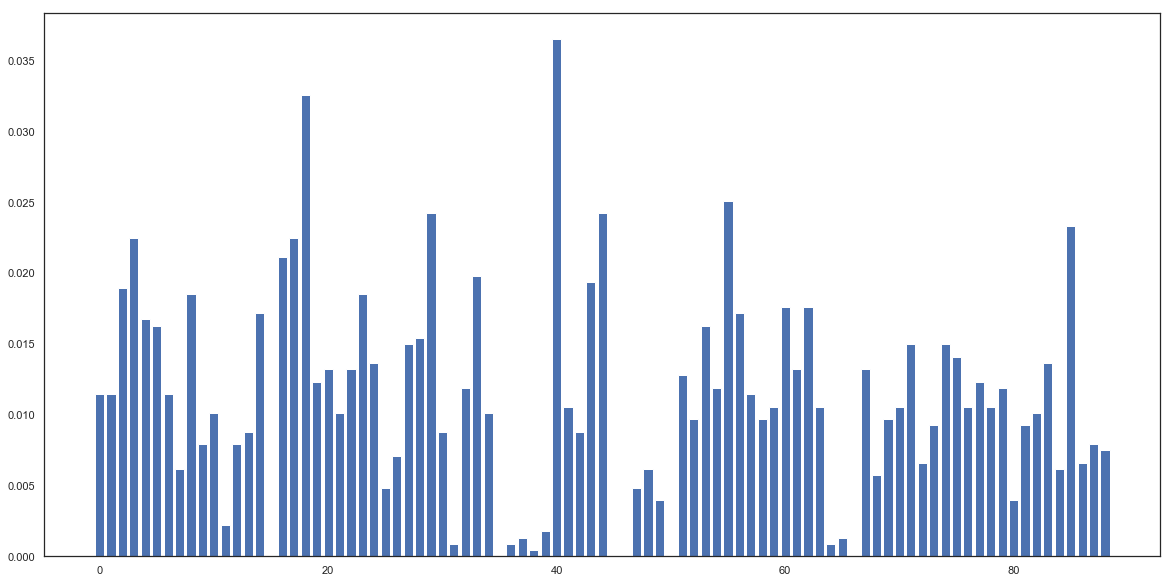

In [398]:
#print(model.feature_importances_)
from matplotlib import pyplot

# plot
plt.figure(figsize = (20,10))
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)

pyplot.show()

### Lets now list the top churn indicator in decreasing order of importance

In [403]:
sorted_idx = np.argsort(model.feature_importances_)[::-1]
df = pd.DataFrame(columns=['index','feature','importance'])
for index in sorted_idx:
    row = {'index':index,'feature':data_hv_reduced.columns[index],'importance':model.feature_importances_[index]}
    df = df.append(row,ignore_index=True)
#    print([X.columns[index], model.feature_importances_[index]]) 

df[df.importance>0].sort_values(by='importance',ascending=False).head(20)


,index,feature,importance
0,40,aon,0.036532
1,18,loc_ic_t2m_mou_8,0.032570
2,55,loc_ic_t2f_mou_1,0.025088
3,29,last_day_rch_amt_8,0.024208
4,44,avg_rech_amt_both_8,0.024208
5,85,total_rech_amt_data_1,0.023327
6,3,roam_og_mou_8,0.022447
7,17,loc_ic_t2t_mou_8,0.022447
8,16,total_og_mou_8,0.021127
9,33,vol_2g_mb_8,0.019806


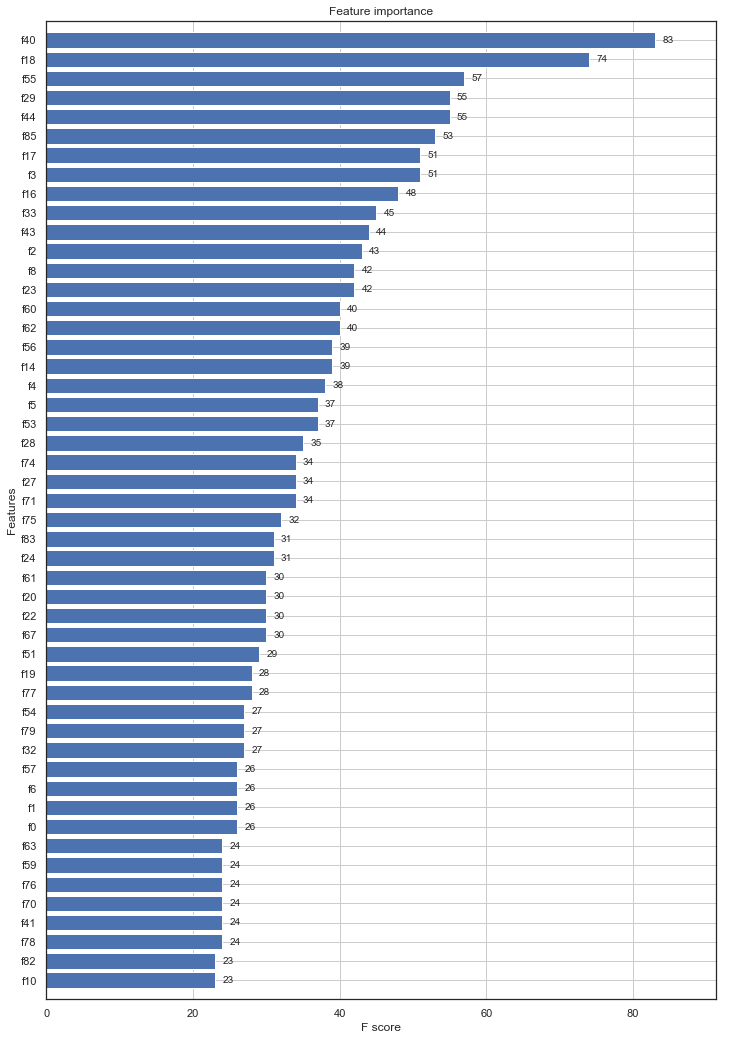

In [401]:
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()